In [1]:
using SciMLBase
using OrdinaryDiffEq
using ForwardDiff
import ForwardDiff: jacobian

using StaticArrays
using LinearAlgebra
using Statistics

using JLD2
using Dates

using PyPlot

In [2]:
using DifferentialEquations

In [3]:
abstract type ODEType end
abstract type AbstractTask end

---
## Загрузка библиотек и модулей

---

In [4]:
include("Utils\\Anon_Utils.jl")
include("Utils\\CallBack_Utils.jl")
include("Utils\\Computation_Utils.jl")
include("Tasks\\ODE_Solving_Task.jl")
include("ODEs\\SL_ODE.jl")
include("Utils\\Visualization_Utils.jl")
include("Utils\\Period_Utils.jl")
include("Utils\\Session_Utils.jl")

---

## Система Стюарта-Ландау

---

In [63]:
r = 1.0
omega = 1.0
s = 1/4

SL = SL_ODE(r, omega, s)

time_span = 100.0
ic = [1.0, 0.0]

trans_time = 10.0
alg = DP8()
callback = nothing
kwargs = Dict{Symbol, Any}(:dt => 1e-1, :abstol => 1e-13, :reltol => 1e-13, :maxiters => 1e10)
diffeq = Dict{Symbol, Any}(:alg => alg, :abstol => 1e-13, :reltol => 1e-13, :maxiters => 1e10, :dt => 1e-1)


ODESolve = ODESolve_Task(SL, time_span, ic; trans_time, alg, callback, kwargs)

[ODE::SL_ODE]: [r::Float64]: 1.0
[omega::Float64]: 1.0
[s::Float64]: 0.25

[time_span::Float64]: 100.0
[init_cond::Vector{Float64}]: [1.0, 0.0]
[trans_time::Float64]: 10.0
[alg::DP8{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}]: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))
[callback::Nothing]: nothing
[kwargs::Dict{Symbol, Any}]: Dict{Symbol, Any}(:maxiters => 1.0e10, :reltol => 1.0e-13, :abstol => 1.0e-13, :dt => 0.1)
[solution::Nothing]: nothing


In [64]:
mutable struct Trajectory{T} <: Function
    ODE::T # Function with signature f(dX, u, p, t) or f(u, p, t)
    t0::Float64
    u0::Vector{Float64}

    ## Optional fields ##
    alg::Union{Any, Nothing}
    kwargs::Union{Dict{Symbol, Any}, Nothing}

    points::Dict{Float64, Vector{Float64}}

    function Trajectory(ODE::T, t0, u0;
                        alg = nothing,
                        kwargs::Union{Dict{Symbol, Any}, Nothing} = Dict{Symbol, Any}()) where T <: ODEType
        kwargs[:save_everystep] = false
        new{T}(ODE, t0, u0, alg, kwargs, Dict())
    end
end

In [116]:
function (trj::Trajectory)(t::Vector)
    return trj(t[1])
end

function (trj::Trajectory)(t::Real)
    #if haskey(trj.points, t)
    #    return trj.points[t]
    #end

    prob_julia = ODEProblem{true, SciMLBase.FullSpecialize}(trj.ODE, trj.u0, (trj.t0, t))
    sol_julia = solve(prob_julia, trj.alg; trj.kwargs...)
    new_point = Pair(sol_julia.t[end], sol_julia.u[end])
    push!(trj.points, new_point)
    return new_point
end

In [73]:
u0 = ic
t0 = 0.0

trj = Trajectory(SL, t0, ic; alg, kwargs)

(::Trajectory{SL_ODE}) (generic function with 1 method)

In [117]:
func = x -> norm(trj(0.0)[2] .- trj(x)[2])

#52 (generic function with 1 method)

In [113]:
using Optim

In [119]:
s = optimize(func, [2*pi + 0.1])

 * Status: success

 * Candidate solution
    Final objective value:     9.262333e-08

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    14
    f(x) calls:    31


In [124]:
s.minimizer[1] - 2*pi

9.26233907350138e-8

In [9]:
sol = ODESolve()

[t]: 698-element Vector{Float64}
[y]: 2-element Vector{Vector{Float64}} with size 698
[t_events]: 1-element Vector{Vector{Float64}} with size 0
[y_events]: 1-element Vector{Matrix{Float64}} with size 0x0
[retcode]: Success


### Time series

In [10]:
title = "Stuart-Landau"
plotKwargs = Dict(:linewidth => 3)

TS_properties = Dict("title" => title, "kwargs" => plotKwargs)

Dict{String, Any} with 2 entries:
  "kwargs" => Dict(:linewidth=>3)
  "title"  => "Stuart-Landau"

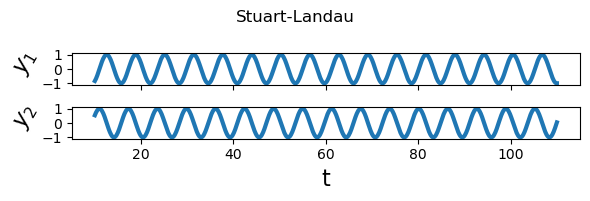

In [11]:
fig = plotTimeSeries(sol; plot_properties = TS_properties);

### Period

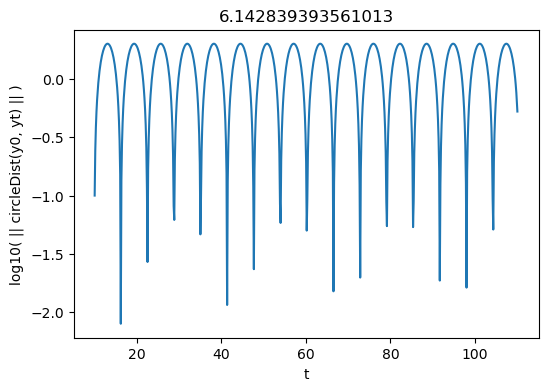

In [12]:
plotNorms(sol)

In [13]:
period = getPeriodTime(sol)

6.142839393561013

### Tangent system

In [14]:
SL_tg = TangentODE(SL, 2)

time_span = period
u0 = [1.0, 0.0]
Q0 = [1.0 0.0; 0.0 1.0]

alg = DP8()
kwargs = Dict(:dt => 1e-1, :abstol => 1e-13, :reltol => 1e-13, :maxiters => 1e10)

ODESolve = TanODESolve_Task(SL_tg, time_span, u0, Q0; alg, kwargs)

[ODE::TangentODE]: [ODE::SL_ODE]: [r::Float64]: 1.0
[omega::Float64]: 1.0
[s::Float64]: 0.25

[Jacobian::var"#27#29"{SL_ODE, Int64}]: #27
[ODEDim::Int64]: 2
[JacDim::Int64]: 2

[time_span::Float64]: 6.142839393561013
[u0::Vector{Float64}]: [1.0, 0.0]
[Q0::Matrix{Float64}]: [1.0 0.0; 0.0 1.0]
[alg::DP8{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}]: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))
[kwargs::Dict{Symbol, Any}]: Dict{Symbol, Any}(:maxiters => 1.0e10, :reltol => 1.0e-13, :abstol => 1.0e-13, :dt => 0.1)
[solution::Nothing]: nothing


In [15]:
tansol = ODESolve()

[t]: 44-element Vector{Float64}
[y]: 6-element Vector{Vector{Float64}} with size 44
[t_events]: 1-element Vector{Vector{Float64}} with size 0
[y_events]: 1-element Vector{Matrix{Float64}} with size 0x0
[retcode]: Success


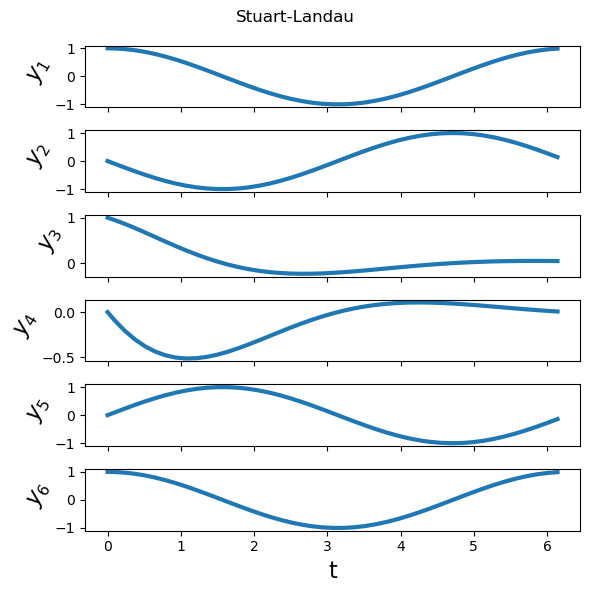

In [16]:
fig = plotTimeSeries(tansol; plot_properties = TS_properties);

In [17]:
W = [y[end] for y in tansol.y][3:6]

4-element Vector{Float64}:
  0.04589951693514927
  0.006484440270374663
 -0.13988563548729252
  0.9901676671071511

In [18]:
reshape(W, (2, 2))

2×2 Matrix{Float64}:
 0.0458995   -0.139886
 0.00648444   0.990168